In [1]:
import pydotplus
import numpy as np
import sklearn.datasets
from sklearn.datasets import load_iris
from sklearn import tree
from sklearn import preprocessing
from IPython.display import Image, display
import MySQLdb

/home/adrianekas/anaconda2/envs/tensorflow/lib/python2.7/site-packages/scipy/sparse/lil.py:19: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _csparsetools
/home/adrianekas/anaconda2/envs/tensorflow/lib/python2.7/site-packages/scipy/sparse/csgraph/__init__.py:165: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._shortest_path import shortest_path, floyd_warshall, dijkstra,\
/home/adrianekas/anaconda2/envs/tensorflow/lib/python2.7/site-packages/scipy/sparse/csgraph/_validation.py:5: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._tools import csgraph_to_dense, csgraph_from_dense,\
/home/adrianekas/anaconda2/envs/tensorflow/lib/python2.7/site-packages/scipy/sparse/csgraph/__init__.py:167: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._traversal

In [2]:
class TanyaJobTreeInput:
    degree = ''
    major = ''
    industry = ''
    age = 0 
    field = ''
    location = ''
    job_level = ''
    work_exp = 0
    
    def __init__(self) :
        self.degree = ''
        self.major = ''
        self.industry = ''
        self.age = 0 
        self.field = ''
        self.location = ''
        self.job_level = ''
        self.work_exp = 0

In [15]:
class TanyaJobTree:
    decision_tree_classifier = sklearn.tree.tree.DecisionTreeClassifier()
    collection = sklearn.datasets.base.Bunch()
    clf = tree.DecisionTreeClassifier()
    
    degree_data = []
    major_data = []
    industry_data = []
    field_data = []
    location_data = []
    job_level_data = []

    def get_data(self,cursor, query):
        cursor.execute(query)
        return cursor.fetchall()
    
    def display_image(self):
        dot_data = tree.export_graphviz(self.decision_tree_classifier, out_file=None,
                                        feature_names=self.collection.feature_names,
                                        class_names=self.collection.target_names,
                                        filled=True, rounded=True)

        graph = pydotplus.graph_from_dot_data(dot_data)
        display(Image(data=graph.create_png()))
        
    def train_model(self,max=999999):
        self.clf = tree.DecisionTreeClassifier(max_depth=max)
        self.clf = self.clf.fit(self.collection.data, self.collection.target)
        return self.clf
        
    def transform(self, input_data, tipe):
        if tipe == "degree":
            for x,y in self.degree_data: 
                if y == input_data:
                    return x
        elif tipe == "major":
            for x,y in self.major_data: 
                if y == input_data:
                    return x   
        elif tipe == "industry":
             for x,y in self.industry_data: 
                if y == input_data:
                    return x
        elif tipe == "field":
             for x,y in self.field_data: 
                if y == input_data:
                    return x
        elif tipe == "location":
             for x,y in self.location_data: 
                if y == input_data:
                    return x
        elif tipe == "job_level":
             for x,y in self.job_level_data: 
                if y == input_data:
                    return x

    def decide(self, input_data):
        if (input_data).__class__.__name__ != 'TanyaJobTreeInput':
            return "Input's type must be TanyaJobTreeInput";
        
        list_value_input = [
            self.transform(input_data.degree, 'degree'),
            self.transform(input_data.major, 'major'),
            self.transform(input_data.industry, 'industry'),
            input_data.age,
            self.transform(input_data.field, 'field'),
            self.transform(input_data.location, 'location'),
            self.transform(input_data.job_level, 'job_level'),
            input_data.work_exp
        ]
        
        value_input = np.array(list_value_input)
        return self.decision_tree_classifier.predict(value_input.reshape(1, -1))
    

    def __init__(self) :
        conn=MySQLdb.connect(host='103.236.201.20',user='skripsi_dev',passwd='tanyajob_dev', database='tanyajob')
        cursor = conn.cursor()
        query = """
            SELECT 
            users.name,
            master_degrees.id,
            master_majors.id,
            master_industries.id,
            YEAR(CURDATE()) - YEAR(users.date_of_birth) AS age,
            master_fields.id,
            master_locations.id,
            master_job_levels.id,
            work_experiences.salary_lower + salary_upper / 2 as average_salary,
            if (current = 1 OR work_experiences.started_work_at > work_experiences.ended_work_at, 
                DATEDIFF(CURDATE(),work_experiences.started_work_at), 
                DATEDIFF(work_experiences.ended_work_at,work_experiences.started_work_at)) / 30
            as work_duration
            FROM users
            JOIN work_experiences ON users.id = work_experiences.user_id
            JOIN master_degrees ON users.last_degree_id = master_degrees.id
            JOIN master_majors ON users.major_id = master_majors.id 
            JOIN master_industries ON master_industries.id = work_experiences.industry_id
            JOIN master_fields ON master_fields.id = work_experiences.field_id
            JOIN master_locations ON master_locations.id = work_experiences.location_id
            JOIN master_job_levels ON master_job_levels.id = work_experiences.job_level_id;
        """
        query_degree = "SELECT id, name FROM master_degrees"
        query_major = "SELECT id, name FROM master_majors"
        query_industry = "SELECT id, name FROM master_industries"
        query_field = "SELECT id, name FROM master_fields"
        query_location = "SELECT id, name FROM master_locations"
        query_job_level = "SELECT id, name FROM master_job_levels"
        
        #type data nya tuple
        retrieved_data = self.get_data(cursor, query)
        self.degree_data = self.get_data(cursor, query_degree)
        self.major_data = self.get_data(cursor, query_major)
        self.industry_data = self.get_data(cursor, query_industry)
        self.field_data = self.get_data(cursor, query_field)
        self.location_data = self.get_data(cursor, query_location)
        self.job_level_data = self.get_data(cursor, query_job_level)
        
        temp_datas = []
        temp_targets = []
        for d in retrieved_data:
            temp_data = [d[1],d[2],d[3],d[4],d[5],d[6],d[7],float(d[9])]
            temp_target = str(d[8])
            temp_datas.append(temp_data)
            temp_targets.append(temp_target)
            
    
        self.collection = sklearn.datasets.base.Bunch(
                data=np.array(temp_datas), 
                target=np.array(temp_targets),
                feature_names=["Last Degree", "Major", "Industry","Age","Fields","Locations","Job Levels","Work Exp"], 
                target_names=temp_targets)
        self.decision_tree_classifier = self.train_model()

In [16]:
x = TanyaJobTree()

In [17]:
x.transform('Staff', 'job_level')

2L

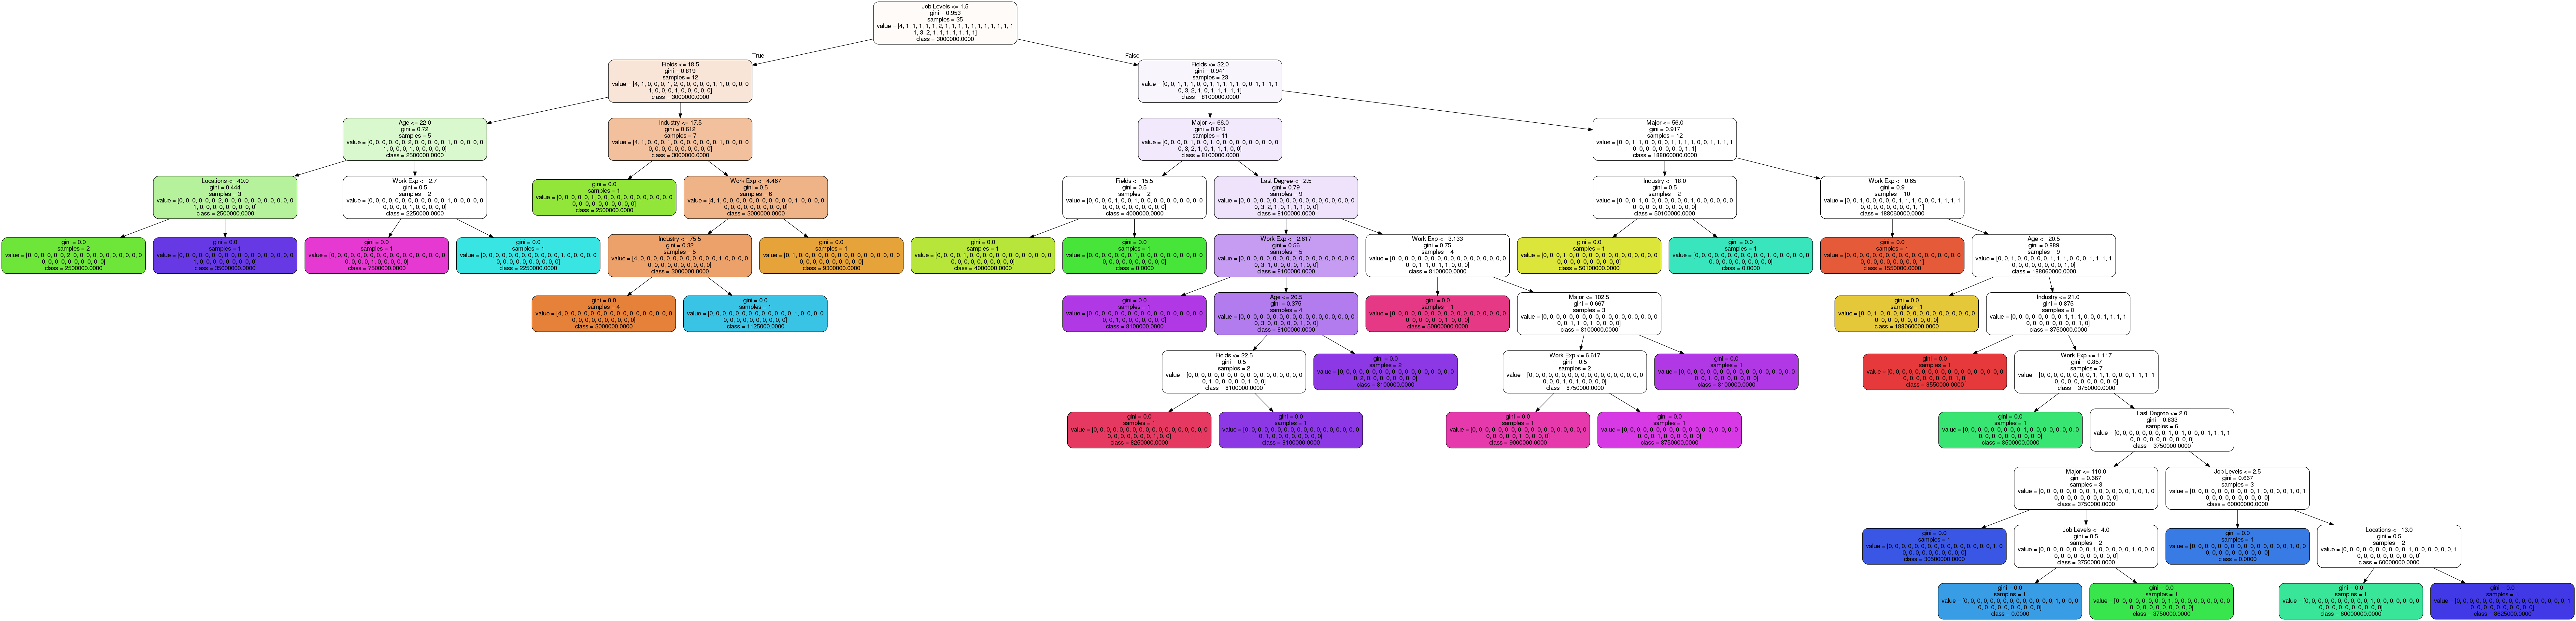

In [18]:
x = TanyaJobTree()
x.display_image()

In [22]:
input_data = TanyaJobTreeInput()
input_data.degree = 'SMA'
input_data.major = 'Arsitektur'
input_data.industry = 'Agribisnis'
input_data.age = 21
input_data.field = 'Juru Masak'
input_data.location = 'Malang'
input_data.job_level = 'Asisten Manajer'
input_data.work_exp = 1.1667


(input_data).__class__.__name__


x.decide(input_data)


[  1.     122.      32.      21.      54.      24.       5.       1.1667]


array(['3000000.0000'], dtype='|S14')